"Кардиоцентр_стажировка (новички) 01.07 | Резер Артем"

**2023-09-29**

Исправлена ошибка: даты рождения присоединялись к основным данным неправильно (Александр, спасибо за багрепорт!)

**2023-09-28**

Ноутбук теперь работает и в Google Colab, и в Jupyter

**2023-09-26**

- Добавен TPOT для автоматического подбора модели
- Запускается на нескольких наборах признаков, для разных отчечек уровня значимости признака
- Данные помещены в `data/*`

**2023-09-17**

Добавлена функция stratified_patient_split (АИ = Александр Ильенко)

**2023-09-13**

Добавлен набор функций для создания дополнительных колонок (АС = Андрей Совцов):

- Отклонение (лет) от критического возраста
- Разбиение возраста по корзинам. Функция назначения номера возрастной группы по значению возраста
- Добавление знаков зодиака
- Функция развертывания значений указанных категориальных колнок в One-Hot-Encoded векторы

# Подготовка среды
Определяем и запоминаем, находимся ли мы в Google Colab.

В Colab-е многие пакеты уже предустановлены, а недостающие добавим (см. код ниже).

В среде Jupyter мы один раз устанавливаем библиотеки из `requirements.txt`:
```
pip install -r requirements.txt
```

In [1]:
%%bash
# Если мы работаем в Google Colab, то устанавливаем недостающие библиотеки

[[ ! -e /content ]] && exit

pip install catboost --quiet
pip install feature_engine --quiet
pip install phik --quiet
pip install tpot --quiet
pip install zodiac-sign --quiet

In [2]:
# Переменная IN_COLAB показывает, находимся ли мы в Google Colab

try:
  import google.colab
  IN_COLAB = True
except ImportError:
  IN_COLAB = False

In [3]:
IN_COLAB

False

## Импорт библиотек

In [4]:
import os
from pprint import pp  # красивая печать; pp - это улучшенная pprint.pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import xgboost as xgb

from catboost import CatBoostRegressor
from feature_engine.imputation import DropMissingData
from lightgbm import LGBMRegressor

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from tqdm.notebook import tqdm  # индикатор прогресса

In [ ]:
if IN_COLAB:
    import gdown

## Вспомогательные функции

In [5]:
# Функция для удобного отображения dataframe-ов в Google Colab-е
# (сортировка, фильтр, страницы, два знака после запятой...)

if IN_COLAB:

    from google.colab import data_table
    data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.2f}"

    def preview(df, show_all_rows=False, **kwargs):
        if show_all_rows:
            num_columns_per_page = df.shape[0]
        else:
            num_columns_per_page = 3

        return data_table.DataTable(
            df,
            num_rows_per_page=num_columns_per_page,
            max_columns = df.shape[1],  # показываем все колонки
            **kwargs
        )

else:

    def preview(df, **kwargs):
        return df

In [6]:
# TODO

# Функция для удобного отображения dataframe-ов в Jupyter Notebook

# !pip install itables
# from itables import init_notebook_mode

# init_notebook_mode(all_interactive=False)
# from itables import show

# def preview(df, show_all_rows=False, **kwargs):
#     with pd.option_context("display.float_format", "{:,.2f}".format):
#         show(df)
#     if show_all_rows:
#         num_columns_per_page = df.shape[0]
#     else:
#         num_columns_per_page = 3

#     return data_table.DataTable(
#         df,
#         num_rows_per_page=num_columns_per_page,
#         max_columns = df.shape[1],  # показываем все колонки
#         **kwargs
#     )

In [7]:
RANDOM_SEED = 0

def reset_random_number_generators(seed=0):
    # random.seed(seed)
    np.random.seed(seed)

# Для воспроизводимости результатов сбрасываем датчики случайных чисел
reset_random_number_generators()

## Создание структуры папок

In [8]:
if IN_COLAB:
    ROOT_PATH = '/content'
else:
    ROOT_PATH = r'C:\Users\Sovtsov\Documents\УИИ\Стажировка\Cardiocenter_n3-main'

In [9]:
# TODO
# Создаем структуру директорий как в репозитории

os.makedirs(f'{ROOT_PATH}/data/raw', exist_ok=True)
os.makedirs(f'{ROOT_PATH}/data/interim', exist_ok=True)
os.makedirs(f'{ROOT_PATH}/data/processed', exist_ok=True)

# Загрузка данных

In [10]:
if IN_COLAB:
    # загружаем в colab Копия ЦАТ_общий_parsed_extDS_v6.xlsx
    url = 'https://drive.google.com/uc?export=download&id=1ZdF0dESb9BIzj7yp75IM3GIJeDO7cyVg'
    output = 'Копия ЦАТ_общий_parsed_extDS_v6.xlsx'
    gdown.download(url, f'{ROOT_PATH}/data/raw/', quiet=True, fuzzy=True)

In [11]:
if IN_COLAB:
    url = 'https://drive.google.com/uc?export=download&id=16uQqSmv428NRlJ-xDFpHJyNT7RTnFLjf'
    gdown.download(url, f'{ROOT_PATH}/data/interim/', quiet=True, fuzzy=True)

In [12]:
def load_dataset():
    # загружаем Копия ЦАТ_общий_parsed_extDS_v6.xlsx в dataframe pandas
    df = pd.read_excel(f'{ROOT_PATH}/data/raw/Копия ЦАТ_общий_parsed_extDS_v6.xlsx', decimal=",")

    # загружаем информацию о датах рождения
    birthdates_df = pd.read_excel(f'{ROOT_PATH}/data/interim/dataset_wide_birthday.xlsx', decimal=',')

    # проверяем корректность: если id совпал, то и birthdate - тоже
    is_birthdates_equal = birthdates_df.groupby('id')['birthdate'].transform(lambda x: x.nunique() == 1)
    assert is_birthdates_equal.all(), (
        'В данных о датах рождения в строках с одинаковым id'
        ' ожидаются одинаковые даты рождения.'
    )

    # удаляем строки с повторяющимися id
    # (выше проверили, что если id совпал, то и birthdate - тоже)
    unique_birthdates_df = birthdates_df.sort_values('id').drop_duplicates(subset='id')

    # объединяем датафреймы по ключу id, оставляя только колонку birthdate из birthdays_df
    merged_df = df.merge(
        unique_birthdates_df[['id', 'birthdate']], on='id', how='left'
    )
    assert merged_df.shape[0] == df.shape[0], (
        'Ожидается, что при заполнении дат рождения'
        ' количество случаев не изменится.'
    )

    return merged_df

df = load_dataset()
print(f'Загружено случаев: {df.shape[0]}')
df.head(3)

Загружено случаев: 1468


,institution,id,gender,age,dose,date_analyse,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,pass_dose,institution_id,diagnos,sss,birthdate
0,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,0,57,7.5,2022-11-11,3.11,1,0,0,13.0,3.32,1,0,20,Фибрилляция предсердий,NaN,1965-11-11
1,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,0,57,7.5,2022-11-24,3.32,1,0,0,15.0,2.01,2,0,20,Фибрилляция предсердий,NaN,1965-11-11
2,ГБУЗ РБ Толбазинская ЦРБ,140361892057264,1,50,5.0,2022-11-22,2.01,0,1,0,26.0,2.75,1,0,20,ПротезированиеМитрального клапана,NaN,1972-11-22


# Подготовка данных (preprocessing)

In [13]:
def to_Xy(df):
    """
    Разделение набора данных на свободные переменные X и зависимую переменную y.
    """
    X = df.drop('dose', axis=1)
    y = df['dose']
    return X, y

## Парсинг данных - выделение по группам (оставлен код исходного парсера)
* возрастов
* диагнозов
* вычисление относительной даты анализа

In [15]:
# В файл ЦАТ_общий_parsed_extDS_v6.xlsx относительно ЦАТ_общий_parsed.xlsx
# добавлены:
# institution_id - id лечебного учреждения (на основании первого столбца с названием)
# diagnos и sss - записи о диагнозе и сердечно-сосудистых событиях из первичных файлов

# Группы диагнозов: обрабатываются поля диагнозов и сердечно-сосудистых событий
# d1 - Протезирование клапанов
# d2 - (I48)Фибрилляция и трепетание предсердий, мерцательная аритмия
# d3 - (I20-25)Ишемическая болезнь сердца(ИБС), инфаркт миокарда(ИМ,ОИМ), Хроническая ишемическая болезнь сердца, Постинфарктный крдиосклероз(ПИКС),Врождённый порок сердца(ВПС), эндокардит,острый коронарный синдром(ОКС),транзиторная ишемическая атака(ТИА), порок
# d4 - (I05-09)Ревматическая болезнь сердца
# d5 - (I35)Неревматические поражения аортального клапана
# d6 - (I__)Другие не сердечные заболевания, гипертония(ГБ), тромбофлебит, острое нарушение мозгового кровообращения,ОНМК,тромбоэмболия лёгочной артерии(ТЭЛА)
# d7 - аортальный, митральный порок сердца, поражение клапанов, недостаточность, межсердные перегородки
# d8 - Стентирование сосудов, биопластика(БАП), радиочастотеая катетерная абляция(РЧА),аблация,электростимуляторы(ЭКС),Шунтирование(АКШ,МКШ)

# Группы возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

# Относительная давность анализа:
# date_from_1990 = количество дней от 01.01.1990 до date_analyse

In [14]:
import os
# import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from datetime import datetime
# import phik
# from phik import resources, report

## Функции для формирования доп.колонок (код сохранен без изменений исходного парсера).
Создаются новые столбцы по группам возрастов, по группам заболеваний и столбец с относительной давностью анализа:  date_from_1990

In [15]:
# Сформируем колонки по группам возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

def get_level(x):
# age_level	0-10-30-50-60-70-80-90+
    if x < 10 : return 0
    if x >= 10 and x < 30 : return 10
    if x >= 30 and x < 50 : return 30
    if x >= 50 and x < 60 : return 50
    if x >= 60 and x < 70 : return 60
    if x >= 70 and x < 80 : return 70
    if x >= 80 and x < 90 : return 80
    return 90

def get_level1(x):
# age_level1	0-50-65-75-80+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 75 : return 65
    if x >= 75 and x < 80 : return 75
    return 80

def get_level2(x):
# age_level2	0-35-50-65-80+
    if x < 35 : return 0
    if x >= 35 and x < 50 : return 35
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 80 : return 65
    return 80

def get_level3(x):
# age_level3	0-50-65-75-90+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 75 : return 65
    if x >= 75 and x < 90 : return 75
    return 90

def get_level4(x):
# age_level4	0-50-65-80
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 80 : return 65
    return 80

def get_level5(x):
# age_level5	0-50-65+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    return 65

In [16]:
# поисковые конструкции для diagnos и sss
# for d1 -диагноз или ссс содержат слово "проте"
# for d2- фибр, фебр,ФП,трепет,i48,I48,I 48
# for d3- порок,ИБС,склероз,ОИМ,инфаркт,миокард,стенокар,I20,I25,ПИКС,пикс,ишемич,кард,ВПС,ОКС,стенокардия,ТИА,эндокардит,порок
# for d4-  I 08,I05,i05,i08,I06,I09,ревмат,
# for d5-  I35,i35
# for d6 - ДКМП, I42, ОНМК,i34,Q231,ГБ,легочн,ТЭЛА
# for d7 - аорт, митр,клап,перегор
# for d8 - АКШ,МКШ,шунт,стент,ЭКС,РЧА,аблац

def get_d1(x):
  # for d1 -диагноз или ссс содержат слово "проте"
  wlist = ['проте']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d2(x):
# for d2- фибр, фебр,ФП,трепет,i48,I48,I 48
  wlist = ['фибр', 'фебр','ФП','трепет','i48','I48','I 48']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d3(x):
# for d3- порок,ИБС,склероз,ОИМ,инфаркт,миокард,стенокар,I20,I25,ПИКС,пикс,ишемич,кард,ВПС,ОКС,стенокардия,ТИА,эндокардит,порок
  wlist = ['порок','ИБС','склероз','ОИМ','инфаркт','миокард','стенокар','I20',
           'I25','ПИКС','пикс','ишемич','кард','ВПС','ОКС','стенокард',
           'ТИА','эндокардит','порок']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d4(x):
# for d4-  I 08,I05,i05,i08,I06,I09,ревмат,
  wlist = ['I 08','I05','i05','i08','I06','I09','ревмат']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d5(x):
# for d5-  I35,i35
  wlist = ['I35','i35']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d6(x):
# for d6 - ДКМП, I42, ОНМК,i34,Q231,ГБ,легочн,ТЭЛА
  wlist = ['ДКМП', 'I42', 'ОНМК','i34','Q231','ГБ','легочн','ТЭЛА']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d7(x):
# for d7 - аорт, митр,клап,перегор
  wlist = ['аорт', 'митр','клап','перегор']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d8(x):
# for d8 - АКШ,МКШ,шунт,стент,ЭКС,РЧА,аблац
  wlist = ['АКШ','МКШ','шунт','стент','ЭКС','РЧА','аблац']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

In [17]:
def add_date_from_1990(df):
    # Вычисли относительную давность анализа:
    # сформируем колонку date_from_1990 = количество дней от 01.01.1990 до date_analyse
    date_01011990 = datetime(1990, 1, 1)

    df['date_from_1990'] = (df['date_analyse'] - date_01011990).dt.days
    return df

In [18]:
def add_age_levels(df):
    """
    Сформируем колонки по группам возрастов: на основе поля возраст
        age_level	0-10-30-50-60-70-80-90+
        age_level1	0-50-65-75-80+
        age_level2	0-35-50-65-80+
        age_level3	0-50-65-75-90+
        age_level4	0-50-65-80
        age_level5	0-50-65+
        age_level6	0-65+
    """
    df['age_level'] = df['age'].apply(get_level)
    df['age_level1'] = df['age'].apply(get_level1)
    df['age_level2'] = df['age'].apply(get_level2)
    df['age_level3'] = df['age'].apply(get_level3)
    df['age_level4'] = df['age'].apply(get_level4)
    df['age_level5'] = df['age'].apply(get_level5)
    df['age_level6'] = np.where((df.age>=65), 65, 0)

    return df

## Сформируем колонки по диагнозам и ССС

In [19]:
def add_diagnosis_and_sss(df):
    """
    Сформируем колонки по диагнозам и ССС: на основе колонок diagnos, sss
        d1 - Протезирование клапанов
        d2 - (I48)Фибрилляция и трепетание предсердий, мерцательная аритмия
        d3 - (I20-25)Ишемическая болезнь сердца(ИБС), инфаркт миокарда(ИМ,ОИМ), Хроническая ишемическая болезнь сердца, Постинфарктный крдиосклероз(ПИКС),Врождённый порок сердца(ВПС), эндокардит,острый коронарный синдром(ОКС),транзиторная ишемическая атака(ТИА), порок
        d4 - (I05-09)Ревматическая болезнь сердца
        d5 - (I35)Неревматические поражения аортального клапана
        d6 - (I__)Другие не сердечные заболевания, гипертония(ГБ), тромбофлебит, острое нарушение мозгового кровообращения,ОНМК,тромбоэмболия лёгочной артерии(ТЭЛА)
        d7 - аортальный, митральный порок сердца, поражение клапанов, недостаточность, межсердные перегородки
        d8 - Стентирование сосудов, биопластика(БАП), радиочастотеая катетерная абляция(РЧА),аблация,электростимуляторы(ЭКС),Шунтирование(АКШ,МКШ)
    """
    # приводим к типу 'str'
    df['diagnos'] = df['diagnos'].astype(str)
    df['sss'] = df['sss'].astype(str)

    df['d1'] = df.apply(lambda x: get_d1(x), axis=1)
    df['d2'] = df.apply(lambda x: get_d2(x), axis=1)
    df['d3'] = df.apply(lambda x: get_d3(x), axis=1)
    df['d4'] = df.apply(lambda x: get_d4(x), axis=1)
    df['d5'] = df.apply(lambda x: get_d5(x), axis=1)
    df['d6'] = df.apply(lambda x: get_d6(x), axis=1)
    df['d7'] = df.apply(lambda x: get_d7(x), axis=1)
    df['d8'] = df.apply(lambda x: get_d8(x), axis=1)

    return df

## Расчет статистических метрик по столбцу age. Анализ распределения возраста пациентов

In [20]:
def plot_age_hist(ages):
    """
    Гистограмма распределения возраста.
    """
    # Белый фон с сеткой
    sns.set_style("whitegrid")

    plt.figure(figsize=(10, 6))
    sns.histplot(ages, bins=30, kde=True, color="skyblue")
    plt.title('Распределение возраста')
    plt.xlabel('Возраст')
    plt.ylabel('Количество')
    plt.tight_layout()

# plot_age_hist(df['age'].copy())

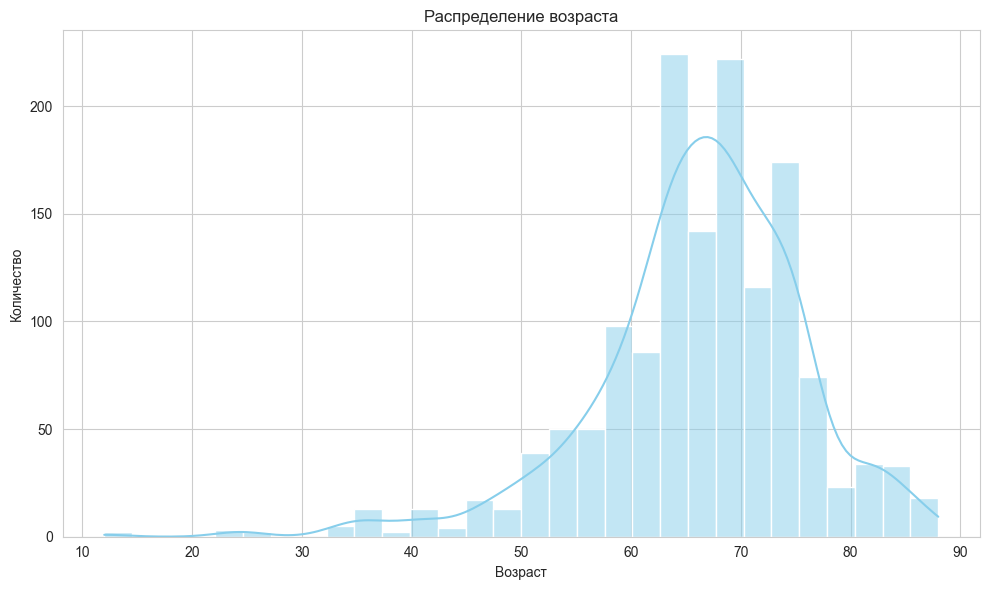

In [21]:
def remove_age_errors(df):
    """
    Удаляем явные ошибки из датасета: возраст 0 и больше 100.
    """
    df = df.drop(df[(df['age'] == 0) | (df['age'] > 100)].index)
    return df

data_age_fixed = remove_age_errors(df.copy())
plot_age_hist(data_age_fixed['age'])

Результат тестов показывает, что что распределение данных в столбце 'age' не следует нормальному распределению. Прямое применение стандартных методов машинного обучения может не давать оптимальных результатов, так как большинство методов предполагает, что признаки имеют некое стандартное или нормальное распределение. Но есть модели, устойчивые к несбалансированным данным: модели на основе деревьев хорошо работают с такими данными.

Для дальнейшей оценки кореляции и принятия решения о включении в датасет на базе занных о возрасте рассчитываются следующие статистические показатели  (можно использовать другие):

**deviation_from_median**: Отклонение возраста от медианного значения возраста в датасете. Если значение положительное, возраст выше медианы; если отрицательное — ниже медианы.

**age_percentile**: Процентное положение возраста относительно всех остальных возрастов в наборе данных. Он показывает, сколько процентов людей в датасете имеют возраст ниже данного значения.

**age_quantile**: Показатель делит возраста на четыре равные части (квартили). При этом значение 1 соответствует самому нижнему квартилю (25% самых молодых), а 4 — самому верхнему квартилю (25% самых старых).

**is_elderly**: Бинарный параметр показывает, превышает ли возраст заданный порог. Если да, то значение равно 1, в противном случае — 0.

**age_density**: Оценка плотности вероятности для каждого возраста в датасете показывает, насколько "обычным" или "редким" является определенный возраст среди всех возрастов в датасете.

**age_zscore**: Z-оценка для возраста показывает, на сколько стандартных отклонений конкретное значение возраста отклоняется от среднего значения возраста в ндатасете. Если Z-оценка положительна, возраст выше среднего, и наоборот.

In [22]:
def add_age_statistics(df):
    df['deviation_from_median'] = df['age'] - df['age'].median()
    df['age_percentile'] = df['age'].apply(lambda x: stats.percentileofscore(df['age'], x))
    df['age_quantile'] = pd.qcut(df['age'], q=4, labels=[1, 2, 3, 4])

    threshold = 70
    df['is_elderly'] = (df['age'] > threshold).astype(int)

    df['age_density'] = df['age'].apply(lambda x: float(stats.gaussian_kde(df['age'])(x)))

    mean_age = df['age'].mean() # средний возраст
    std_age = df['age'].std() # стандартное отклонение
    df['age_zscore'] = (df['age'] - mean_age) / std_age

    return df

## Функции создания дополнительные колонок

In [23]:
# Функция Отклонение (лет) от критического возраста: critical_age_l - младше порога; critical_age_h - старше порога

critical_age_threshold = 40  # принятый порог критического возраста

def critical_age(df,tr_age=critical_age_threshold):
    if 'age' in df.columns and 'int' in df.age.dtype.name:
        df['critical_age_l']=df['age'].apply(lambda x: tr_age - x if x < tr_age else 0 ).astype('int8')
        df['critical_age_h']=df['age'].apply(lambda x: x - tr_age if x > tr_age else 0  ).astype('int8')
    return df

In [24]:
# Функция make_ohe_columns - развертывание значений категориальных колнок в One-Hot-Encoded векторы
# features_to_ohe = [список колонок для развертывания в OHE векторы]

def make_ohe_columns(df):
    # ВНИМАНИЕ: используем внешнюю переменную features_to_ohe = []

    _colist_ = [c for c in list(features_to_ohe) if c in df.columns]
    print(_colist_)

    return pd.get_dummies(df, columns=_colist_, drop_first=False)


# test

# features_to_ohe = ['gender','institution_id','abracadabra']
# # features_to_ohe = 'gender'
# clear_df = make_ohe_columns(df.copy())
# preview(clear_df)

In [25]:
# Разбиение возраста по корзинам
# Функция назначения номера возрастной группы по значению возраста

def add_age_bins(df, ohe=True):
    def bin_age_x(a):
        x = a // 10
        x = 9 if x > 9 else x
        return x

    if 'age' in df.columns and 'int' in df.age.dtype.name:
        df['agebin']=df['age'].apply(lambda x: bin_age_x(x)).astype('int8')
        df = pd.get_dummies(df, columns=['agebin'],drop_first=False) if ohe else df
    return df

### Добавление названий имен знаков зодиака

In [26]:
# Загрузка пакета и функции генерации

from zodiac_sign import get_zodiac_sign

In [27]:
# Разбиение OHE по знакам зодиака
def make_zodiac_ohe(df):
    if 'birthdate' in df.columns:
        df['zodiac']=df['birthdate'].apply(lambda x: get_zodiac_sign(x))
        df = pd.get_dummies(df, columns=['zodiac'], drop_first=False )
    return df

## Создаем очищенный и обогащенный набор данных для обучения моделей

In [30]:
import scipy.stats as stats

In [31]:
# Рецепт, по которому очищаем и обогащаем набор данных

# Список колонок для развертывания в OHE векторы
features_to_ohe = ['gender', 'institution_id']

data_pipeline_wide = make_pipeline(
    FunctionTransformer(add_date_from_1990),
    FunctionTransformer(add_age_levels),
    FunctionTransformer(add_diagnosis_and_sss),
    FunctionTransformer(remove_age_errors),
    FunctionTransformer(add_age_statistics),
    FunctionTransformer(critical_age),
    FunctionTransformer(add_age_bins),
    FunctionTransformer(make_zodiac_ohe),
    FunctionTransformer(make_ohe_columns),
)
data_pipeline_wide

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function add_date_from_1990 at 0x000001DD81975BD0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function add_age_levels at 0x000001DD81975FC0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function add_diagnosis_and_sss at 0x000001DD81977AC0>)),
                ('functiontransformer-4',
                 Functio...
                 FunctionTransformer(func=<function critical_age at 0x000001DD81E1D7E0>)),
                ('functiontransformer-7',
                 FunctionTransformer(func=<function add_age_bins at 0x000001DD85F69870>)),
                ('functiontransformer-8',
                 FunctionTransformer(func=<function make_zodiac_ohe at 0x000001DD85FC5990>)),
                ('functiontransformer-9',
                 FunctionTransformer(func=<function make_ohe_columns at 0x000001DD81CBEC20>))])

In [32]:
# Преобразуем исходные данные согласно рецепту и сохраняем результат в файл

df = load_dataset()
data_wide = data_pipeline_wide.transform(df)

# сохраним датасет со всеми новыми столбцами в виртульное окружение -
# - при необходимости сохраните на локальный диск вручную
data_wide.to_excel(f'{ROOT_PATH}/data/interim/dataset_wide.xlsx', index=False)
data_wide.head(3)

['gender', 'institution_id']


,institution,id,age,dose,date_analyse,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,57,7.5,2022-11-11,3.11,1,0,0,13.0,...,0,0,0,0,0,0,0,0,0,0
1,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,57,7.5,2022-11-24,3.32,1,0,0,15.0,...,0,0,0,0,0,0,0,0,0,0
2,ГБУЗ РБ Толбазинская ЦРБ,140361892057264,50,5.0,2022-11-22,2.01,0,1,0,26.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
data_wide.columns


Index(['institution', 'id', 'age', 'dose', 'date_analyse', 'prev_INR(MHO)',
       'atrial_fibrillation', 'mitral_valve', 'aortal_valve', 'date_diff',
       'INR(MHO)', 'sample', 'pass_dose', 'diagnos', 'sss', 'birthdate',
       'date_from_1990', 'age_level', 'age_level1', 'age_level2', 'age_level3',
       'age_level4', 'age_level5', 'age_level6', 'd1', 'd2', 'd3', 'd4', 'd5',
       'd6', 'd7', 'd8', 'deviation_from_median', 'age_percentile',
       'age_quantile', 'is_elderly', 'age_density', 'age_zscore',
       'critical_age_l', 'critical_age_h', 'agebin_1', 'agebin_2', 'agebin_3',
       'agebin_4', 'agebin_5', 'agebin_6', 'agebin_7', 'agebin_8',
       'zodiac_Aquarius', 'zodiac_Aries', 'zodiac_Cancer', 'zodiac_Capricorn',
       'zodiac_Gemini', 'zodiac_Leo', 'zodiac_Libra', 'zodiac_Pisces',
       'zodiac_Sagittarius', 'zodiac_Scorpio', 'zodiac_Taurus', 'zodiac_Virgo',
       'gender_0', 'gender_1', 'institution_id_1', 'institution_id_2',
       'institution_id_3', 'institut

In [34]:
def remove_unrelated_features(df):
    """
    Удаляем столбцы которые, не влияют на дозу варфарина или переведены
    в иные числовые параметры.
    """
    return df.drop(
        ['institution', 'date_analyse', 'diagnos', 'sss', 'date_from_1990', 'birthdate'],
        axis=1
    )

In [35]:
data_pipeline = make_pipeline(
    *data_pipeline_wide,
    FunctionTransformer(remove_unrelated_features)
)
data_pipeline

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function add_date_from_1990 at 0x000001DD81975BD0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function add_age_levels at 0x000001DD81975FC0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function add_diagnosis_and_sss at 0x000001DD81977AC0>)),
                ('functiontransformer-4',
                 Functio...
                 FunctionTransformer(func=<function add_age_bins at 0x000001DD85F69870>)),
                ('functiontransformer-8',
                 FunctionTransformer(func=<function make_zodiac_ohe at 0x000001DD85FC5990>)),
                ('functiontransformer-9',
                 FunctionTransformer(func=<function make_ohe_columns at 0x000001DD81CBEC20>)),
                ('functiontransformer-10',
                 FunctionTransformer(func=<function remove_unrelated_features at 0x000001DD85F0BAC0>))])

In [36]:
# Трансформируем исходные сырые данные в данные, предназначенные для анализа моделями

df = load_dataset()
data_for_algo = data_pipeline.transform(df)
data_for_algo.to_excel(f'{ROOT_PATH}/data/processed/data_for_model.xlsx', index=False)
data_for_algo.head(3)

['gender', 'institution_id']


,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,140361892057136,57,7.5,3.11,1,0,0,13.0,3.32,1,...,0,0,0,0,0,0,0,0,0,0
1,140361892057136,57,7.5,3.32,1,0,0,15.0,2.01,2,...,0,0,0,0,0,0,0,0,0,0
2,140361892057264,50,5.0,2.01,0,1,0,26.0,2.75,1,...,0,0,0,0,0,0,0,0,0,0


## Удаление наименее важных признаков

### Корреляция признаков

 Анализ корреляции показывает, что добавленные столбцы age_level, часть столбцов d1-d8 и статистические показатели по столбцу возраст  сильно коррелируют с показателями исходного датасета и между собой -  целесообразно рассмотреть их удаление. Но предварительно предлагается провести расчет релевантгности признаков с использованием других методов, которые реализованы в библиотеке sklearn и по результатам принять решение о чистке датасета.

### Наиболее релеваниные признаки
Определениe наиболее релевантных признаков в датасете с использованием методов автоматизированного отбора признаков.

In [37]:
# Подготовка данных
X, y = to_Xy(data_for_algo.dropna())

In [38]:
from sklearn.feature_selection import RFE, f_classif, mutual_info_regression, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import MinMaxScaler

# 1. RFE (Recursive Feature Elimination)
# RFE рекурсивно уменьшает количество признаков, оценивая модель на каждом этапе и выбирая либо лучший, либо худший признак.
estimator = LinearRegression()
selector = RFE(estimator)
selector = selector.fit(X, y)
rfe_features = pd.Series(selector.support_, index=X.columns).apply(lambda x: 1 if x else 0)

# 2. RandomForest
# Случайный лес оценивает важность признаков на основе того, насколько часто каждый признак используется для принятия решений в деревьях.
model_rf = RandomForestRegressor()
model_rf.fit(X, y)
rf_importances = pd.Series(model_rf.feature_importances_, index=X.columns)

# 3. Lasso
# Lasso (линейная регрессия с L1-регуляризацией) может свести вес некоторых признаков к нулю, тем самым исключая их.
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X, y)
lasso_coefficients = pd.Series(model_lasso.coef_, index=X.columns)

# 4. SFS (Sequential Feature Selector)
# SFS последовательно добавляет или удаляет признаки на основе их производительности до достижения заданного числа признаков.
sfs = SFS(LinearRegression(),
          k_features='best',
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)
sfs.fit(X, y)
sfs_features = pd.Series([1 if i in list(sfs.k_feature_idx_) else 0 for i in range(X.shape[1])], index=X.columns)

# 5. ANOVA
# ANOVA (дисперсионный анализ) проверяет, имеют ли две или более группы схожие средние значения. В контексте отбора признаков это может помочь определить,
# влияет ли признак на целевую переменную.
f_scores, _ = f_classif(X, y)
f_features = pd.Series(f_scores, index=X.columns)

# 6. Mutual Information
# Взаимная информация измеряет зависимость между признаком и целевой переменной; ближе к 0 - меньше зависимости, ближе к 1 - более сильная зависимость.
mi_scores = mutual_info_regression(X, y)
mi_features = pd.Series(mi_scores, index=X.columns)

# 7. RFECV (Recursive Feature Elimination with Cross-Validation)
# RFECV сочетает RFE с кросс-валидацией, чтобы выбрать оптимальное количество признаков.
selector = RFECV(estimator)
selector = selector.fit(X, y)
rfecv_features = pd.Series(selector.support_, index=X.columns).apply(lambda x: 1 if x else 0)

# Сводная таблица
feature_table = pd.DataFrame({
    'RFE': rfe_features,
    'RandomForest': rf_importances,
    'Lasso': lasso_coefficients,
    'SFS': sfs_features,
    'Mutual Info': mi_features,
    'RFECV': rfecv_features
})

# Нормализация данных с весами
scaler = MinMaxScaler()
methods_with_weights = ['RandomForest', 'Lasso', 'Mutual Info']
feature_table[methods_with_weights] = scaler.fit_transform(feature_table[methods_with_weights])

# Расчет общей важности и создание рейтинга
feature_table['Total Importance'] = feature_table.sum(axis=1)
feature_ranking = feature_table.sort_values(by='Total Importance', ascending=False)

# preview(feature_ranking)
display(feature_ranking)

C:\Users\Sovtsov\AutoML\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e+03, tolerance: 3.708e-01
  model = cd_fast.enet_coordinate_descent(


,RFE,RandomForest,Lasso,SFS,Mutual Info,RFECV,Total Importance
institution_id_11,1,1.000000,0.000000,1,0.420178,0,3.420178
age_density,1,0.355058,0.654938,1,0.304074,0,3.314070
institution_id_31,1,0.172965,1.000000,1,0.129666,0,3.302631
age,1,0.161520,0.654938,0,0.398134,1,3.214592
deviation_from_median,1,0.158984,0.654938,0,0.398727,1,3.212648
...,...,...,...,...,...,...,...
sample,0,0.058644,0.654356,0,0.000000,0,0.713000
zodiac_Aries,0,0.054212,0.654938,0,0.000000,0,0.709149
age_level2,0,0.022396,0.646445,0,0.024441,0,0.693283
is_elderly,0,0.009319,0.672775,0,0.004008,0,0.686102


In [ ]:
# print(feature_ranking.shape)
# display(feature_ranking.head(43))
# display(feature_ranking.tail(43))

In [39]:
feature_ranking.to_excel(f'{ROOT_PATH}/data/processed/feature_ranking.xlsx', index=False)


### Очистка датасета от лишних признаков

In [40]:
def find_minor_features(feature_ranking_df, rank_threshold):
    """
    """
    # на основании матрицы корреляции и автоматизированного отбора признаков можно предложить  показатели, которые можно удалить из датасета
    # Предлагается удалить показатели из таблицы feature_ranking_df с рейтингом меньше rank_threshold, сохранив столбцы с начальными исходными данными из
    # медицинских учереждений, такие как, например, age и date_diff

    # Признаки, которые нужно сохранить независимо от их рейтинга
    vip_features = [
        'gender_0', 'gender_1',
        'age', 'dose', 'prev_INR(MHO)',
        'atrial_fibrillation', 'mitral_valve', 'aortal_valve',
        'INR(MHO)',
        'date_diff', 'sample',
    ]

    # Список признаков, которые нужно удалить
    features_to_remove = feature_ranking_df[feature_ranking_df['Total Importance'] < rank_threshold].index.tolist()

    # Исключение из этого списка важных признаков, которые оставляем
    features_to_remove = [f for f in features_to_remove if f not in vip_features]

    return features_to_remove

# тест
features_to_remove = find_minor_features(feature_ranking, rank_threshold=1.5)
print('Несущественные признаки, удаляемые из данных:\n')
pp(features_to_remove)

Несущественные признаки, удаляемые из данных:

['age_percentile',
 'institution_id_14',
 'd3',
 'age_quantile',
 'institution_id_29',
 'zodiac_Scorpio',
 'd4',
 'age_level3',
 'age_level',
 'age_level5',
 'd7',
 'zodiac_Virgo',
 'd6',
 'age_level1',
 'agebin_5',
 'zodiac_Capricorn',
 'zodiac_Taurus',
 'zodiac_Sagittarius',
 'institution_id_15',
 'age_level4',
 'age_level6',
 'zodiac_Aries',
 'age_level2',
 'is_elderly',
 'pass_dose']


In [46]:
# Удаляем несущественные признаки из датасета

def remove_features(df, column_names):
    return df.drop(columns=column_names)

# features_to_remove = find_minor_features(feature_ranking, rank_threshold=2)
# clear_df = remove_features(data_for_algo.copy(), features_to_remove)
# clear_df.head(3)

# Полный pipeline для обработки данных
1. Создаем пайплайн
2. Пропускаем через него исходные данные
3. Сохраняем результат - данные, которые будут использоваться моделями




In [42]:
data_pipeline = make_pipeline(
    *data_pipeline_wide,
    FunctionTransformer(remove_unrelated_features),
    # FunctionTransformer(remove_features, kw_args={'column_names': features_to_remove}),
    DropMissingData(),
)
data_pipeline

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function add_date_from_1990 at 0x000001DD81975BD0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function add_age_levels at 0x000001DD81975FC0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function add_diagnosis_and_sss at 0x000001DD81977AC0>)),
                ('functiontransformer-4',
                 Functio...
                 FunctionTransformer(func=<function add_age_bins at 0x000001DD85F69870>)),
                ('functiontransformer-8',
                 FunctionTransformer(func=<function make_zodiac_ohe at 0x000001DD85FC5990>)),
                ('functiontransformer-9',
                 FunctionTransformer(func=<function make_ohe_columns at 0x000001DD81CBEC20>)),
                ('functiontransformer-10',
                 FunctionTransformer(func=<function remove_unrelated_features at 0x000001DD85F0BAC0>)),
                ('dropmissingdata', DropMissingData())])

In [44]:
# Пропускаем исходные данные через сконструированный выше pipeline.
# Результат будем использовать для обучения моделей.

# Загружаем данные из файла (для надежности)
df = load_dataset()
data_for_model = data_pipeline.fit_transform(df)

# сохраним результаты очищенного датасета в виртульное окружение -
# при необходимости сохраните на локальный диск вручную
data_for_model.to_excel(f'{ROOT_PATH}/data/processed/data_for_model.xlsx', index=False)
data_for_model.head(3)

['gender', 'institution_id']


,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,140361892057136,57,7.5,3.11,1,0,0,13.0,3.32,1,...,0,0,0,0,0,0,0,0,0,0
1,140361892057136,57,7.5,3.32,1,0,0,15.0,2.01,2,...,0,0,0,0,0,0,0,0,0,0
2,140361892057264,50,5.0,2.01,0,1,0,26.0,2.75,1,...,0,0,0,0,0,0,0,0,0,0


## Данные с только существенными признаками
Дополнительно изготавливаем и сохраняем данные, в которых оставлены только существенные признаки

In [47]:
data_pipeline = make_pipeline(
    *data_pipeline_wide,
    FunctionTransformer(remove_unrelated_features),
    FunctionTransformer(remove_features, kw_args={'column_names': features_to_remove}),
    DropMissingData(),
)
data_pipeline

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function add_date_from_1990 at 0x000001DD81975BD0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function add_age_levels at 0x000001DD81975FC0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function add_diagnosis_and_sss at 0x000001DD81977AC0>)),
                ('functiontransformer-4',
                 Functio...
                                                               'institution_id_14',
                                                               'd3',
                                                               'age_quantile',
                                                               'institution_id_29',
                                                               'zodiac_Scorpio',
                                                               'd4',
                                                               'age_level3',
                                                               'age_level',
                                                               'age_level5',
                                                               'd7',
                                                               'zodiac_Virgo',
                                                               'd6',
                                                               'age_level1',
                                                               'agebin_5',
                                                               'zodiac_Capricorn',
                                                               'zodiac_Taurus',
                                                               'zodiac_Sagittarius',
                                                               'institution_id_15',
                                                               'age_level4',
                                                               'age_level6',
                                                               'zodiac_Aries',
                                                               'age_level2',
                                                               'is_elderly',
                                                               'pass_dose']})),
                ('dropmissingdata', DropMissingData())])

In [48]:
# Пропускаем исходные данные через сконструированный выше pipeline.
# Результат будем использовать для обучения моделей.

# Загружаем данные из файла (для надежности)
df = load_dataset()
data_for_model = data_pipeline.fit_transform(df)

# сохраним результаты очищенного датасета в виртуальное окружение -
# при необходимости сохраните на локальный диск вручную
data_for_model.to_excel(f'{ROOT_PATH}/data/processed/data_for_model_few_features.xlsx', index=False)
data_for_model.head(3)

['gender', 'institution_id']


,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_21,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_30,institution_id_31
0,140361892057136,57,7.5,3.11,1,0,0,13.0,3.32,1,...,0,0,0,0,0,0,0,0,0,0
1,140361892057136,57,7.5,3.32,1,0,0,15.0,2.01,2,...,0,0,0,0,0,0,0,0,0,0
2,140361892057264,50,5.0,2.01,0,1,0,26.0,2.75,1,...,0,0,0,0,0,0,0,0,0,0


# Построение модели

In [54]:
def stratified_split(df, stratify_column='id', test_size=0.2, random_state=None):
    # Получаем уникальные значения
    unique_ids = df[stratify_column].unique()

    # Разделяем уникальные значения на train и test
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size, random_state=random_state)

    # Разделяем датафрейм на основе id
    train_df = df[df[stratify_column].isin(train_ids)]
    test_df = df[df[stratify_column].isin(test_ids)]

    return train_df, test_df

In [55]:
def stratified_patient_split(df, stratify_column='id', target_column='dose', *, n_bins=4, test_size=0.2, random_state=None):
    """
    Функция разбивает датафрейм на обучающий и тестовый наборы с учетом стратификации по медианным значениям целевой переменной каждого уникального элемента в столбце stratify_column.

    Параметры:
    - df (pd.DataFrame): исходный датафрейм
    - stratify_column (str): имя столбца, по уникальным значениям которого будет вычисляться медиана целевой переменной для стратификации
    - target_column (str): имя целевого столбца, по которому будет осуществляться стратификация
    - n_bins (int): количество интервалов для разделения медианных значений целевой переменной
    - test_size (float): доля данных, которая будет использоваться для тестового набора
    - random_state (int): seed для случайности при разбиении

    Возвращает:
    - train_df (pd.DataFrame): обучающий датафрейм
    - test_df (pd.DataFrame): тестовый датафрейм
    """
    # 1. Вычисляем медианное значение целевой переменной (target_column) для каждого пациента (stratify_column)
    # patient_medians - объект Series из pandas, где  индекс это ID пациента (значения из столбца stratify_column),
    # а значение — медианные значения дозы для каждого пациента из столбца target_column.
    patient_medians = df.groupby(stratify_column)[target_column].median()

    # 2. Определяем границы интервалов с учетом минимального и максимального значений целевой переменной (target_column)
    # отрезок между минимальной и максимальной дозой разбивается на равные интервалы в количестве n_bins. bins - массив с границами интервалов
    bins = np.linspace(df[target_column].min(), df[target_column].max(), n_bins + 1)

    # 3. Классифицируем медианные значения целевой переменной (target_column) по интервалам
    # binned_medians — объект Series, где: Индекс это ID пациента (stratify_column), а значение — это номер интервала, в который попало медианное значение для данного ID.
    binned_medians = pd.cut(patient_medians, bins, labels=False, include_lowest=True)

    # Особенность pd.cut - если количество интервалов большое, то в часть из них может не попасть ни одно значение или попасть только одно.
    # И то и другое не позволяет осуществлять стратификацию с помощью  train_test_split, поскольку в каждом интервале требуется не менее двух значений для обучающей и тестовоы выборок
    # Нижеследующий код до #4. направлен на поиск таких интервалов и присоединение их к соседним, имеющим больше одного значения

    # Рассчитываем количество пациентов в каждом интервале
    bin_counts = binned_medians.value_counts() #.value_counts() - это метод для объектов Series в pandas. Он подсчитывает, сколько раз каждое уникальное значение встречается в Series
    print("Пациентов в интервале:", bin_counts)

    # Если есть интервалы без пациентов. то присваиваем такому интервалу (с индексом i) значение 0
    for i in range(n_bins):
        if i not in bin_counts:
            bin_counts = pd.concat([bin_counts, pd.Series([0], index=[i])])

    # Находим проблемные интервалы, где меньше двух пациентов.
    problematic_bins = bin_counts[bin_counts < 2].index.tolist()
    print('Проблемные интервалы', problematic_bins)

    # Для каждого проблемного интервала пытаемся найти ближайший интервал с более чем одним пациентом
    for bin_num in problematic_bins:
        # Переменная для определения расстояния до проверяемого соседнего интервала
        dist = 1
        while True:
            lower_bin = bin_num - dist
            upper_bin = bin_num + dist
            # Если соседний интервал имеет более чем одного пациента, присваиваем проблемному интервалу номер соседнего интервала (объединяем интервалы)
            if lower_bin in bin_counts and bin_counts[lower_bin] > 1:
                binned_medians[binned_medians == bin_num] = lower_bin
                break
            elif upper_bin in bin_counts and bin_counts[upper_bin] > 1:
                binned_medians[binned_medians == bin_num] = upper_bin
                break
            # Увеличиваем расстояние, чтобы проверить следующие интервалы, если соседние не подошли по условиям
            dist += 1

    # Перерасчитываем количество пациентов в каждом интервале после переназначения проблемных интервалов
    bin_counts = binned_medians.value_counts()
    print("Пациентов в интервале после переназначения проблемных интервалов: ", bin_counts)

    # 4. Разделяем перечень уникальных ID пациентов на обучающую и тестовую выборки с учетом стратификации на основе интервалов по медианным значениям целевой переменной
    # в обучающую и тестовую выборки попадут пропорциональные значению test_size количества ID из каждого интервала binned_medians
    train_ids, test_ids = train_test_split(binned_medians.index, test_size=test_size, stratify=binned_medians, random_state=random_state)

    # 5. Разделяем исходный датафрейм на основе полученных выборок ID пациентов
    train_df = df[df[stratify_column].isin(train_ids)]
    test_df = df[df[stratify_column].isin(test_ids)]

    return train_df, test_df

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split

def qcut_split(df, target_column='dose', *, n_bins=4, test_size=0.2, random_state=42):
    """
    Функция разбивает датафрейм на обучающий и тестовый наборы с учетом стратификации по квантильным значениям целевой переменной.

    Параметры:
    - df (pd.DataFrame): исходный датафрейм
    - target_column (str): имя целевого столбца, по которому будет осуществляться стратификация
    - n_bins (int): количество интервалов для разделения квантильных значений целевой переменной
    - test_size (float): доля данных, которая будет использоваться для тестового набора


    Возвращает:
    - train_df (pd.DataFrame): обучающий датафрейм
    - test_df (pd.DataFrame): тестовый датафрейм
    """

    # Классификация значений целевой переменной (target_column) по квантилям
    binned_target, bins = pd.qcut(df[target_column], q=n_bins, labels=False, duplicates='drop', retbins=True)

    # границы интервалов
    print("Границы интервалов: ", bins)


    # Разбивка индексов датафрейма на обучающую и тестовую выборки с учетом стратификации по квантильным интервалам целевой переменной
    train_idx, test_idx = train_test_split(df.index, test_size=test_size, stratify=binned_target, random_state=random_state)

    # Разбиение исходного датафрейма на обучающий и тестовый наборы на основе полученных индексов
    train_df = df.loc[train_idx]
    test_df = df.loc[test_idx]

    return train_df, test_df

In [56]:
class Experiment:
    """
    Общая схема проведения эксперимента.
        конструктор - определяем конвейер, через который будем пропускать данные
        run(df)     - подаем данные и начинаем эксперимент, собирая метрики
        result      - получаем результат
    """

    def __init__(self, name, pipeline):
        self.name = name
        self.pipeline = pipeline
        self.result = {}

    def __repr__(self):
        return f'<{self.name}>'

    def run(self, df):
        # Разделение исходного датафрейма с использованием stratified_split
        train_df, test_df = stratified_patient_split(df, random_state=42)

        # Извлечение X и y из train_df и test_df
        X_train = train_df.drop('dose', axis=1)
        y_train = train_df['dose']

        X_test = test_df.drop('dose', axis=1)
        y_test = test_df['dose']

        self.pipeline.fit(X_train, y_train)

        y_pred_train = self.pipeline.predict(X_train)
        y_pred_test = self.pipeline.predict(X_test)

        self.result = dict(
            train=self._calculate_metrics(y_pred_train, y_train),
            test=self._calculate_metrics(y_pred_test, y_test),
        )

    @staticmethod
    def _calculate_metrics(y_pred, y_true):
        return {
            'Mean Squared Error': mean_squared_error(y_pred, y_true),
            'R^2': r2_score(y_true, y_pred),
            'MAPE': (abs((y_true - y_pred) / y_true).mean()) * 100,
            'MAE': mean_absolute_error(y_true, y_pred),
            'Average Percent Deviation': (abs((y_true - y_pred) / y_true.mean()) * 100).mean(),
        }

## Описания экспериментов, которые собираемся провести

In [57]:
experiments = {}  # {имя: эксперимент} - для удобства, так легче заменить эксперимент

In [58]:
exp = Experiment('XGBoost', Pipeline([
    ('XGB', xgb.XGBRegressor(objective ='reg:squarederror')),
]))
experiments[exp.name] = exp

exp.pipeline

Pipeline(steps=[('XGB',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [59]:
exp = Experiment('K Neighbors', Pipeline([
    ('KNN', KNeighborsRegressor()),
]))
experiments[exp.name] = exp

exp.pipeline

Pipeline(steps=[('KNN', KNeighborsRegressor())])

In [60]:
exp = Experiment('Linear Regression', Pipeline([
    ('LR', LinearRegression()),
]))
experiments[exp.name] = exp

exp.pipeline

Pipeline(steps=[('LR', LinearRegression())])

In [61]:
exp = Experiment('LightGBM', Pipeline([
    ('LGBM', LGBMRegressor()),
]))
experiments[exp.name] = exp

exp.pipeline

Pipeline(steps=[('LGBM', LGBMRegressor())])

In [62]:
exp = Experiment('Random Forest', Pipeline([
    ('RF', RandomForestRegressor()),
]))
experiments[exp.name] = exp

exp.pipeline

Pipeline(steps=[('RF', RandomForestRegressor())])

In [63]:
exp = Experiment('Gradient Boosting', Pipeline([
    ('GB', GradientBoostingRegressor()),
]))
experiments[exp.name] = exp

exp.pipeline

Pipeline(steps=[('GB', GradientBoostingRegressor())])

In [64]:
exp = Experiment('Cat. Boosting', Pipeline([
    ('CB', CatBoostRegressor(verbose=0)),
]))
experiments[exp.name] = exp

exp.pipeline

Pipeline(steps=[('CB',
                 <catboost.core.CatBoostRegressor object at 0x000001FF84703FD0>)])

👉 Здесь можно добавить свои эксперименты:

In [65]:
# Так можно создавать эксперименты программно:

regressors = [
    ('LGBM', LGBMRegressor()),
    ('GB', GradientBoostingRegressor()),
]
# Строим эксперименты по схеме "скейлер -> регрессор"
for reg_name, reg_obj in regressors:
    name = f'StdScaler -> {reg_name}'
    exp = Experiment(name, Pipeline([
        ('StdScaler', StandardScaler()),
        ('CB', reg_obj),
    ]))
    experiments[name] = exp

# Пример одного из созданных пайплайнов
exp.pipeline

Pipeline(steps=[('StdScaler', StandardScaler()),
                ('CB', GradientBoostingRegressor())])

In [66]:
print('Запланированные эксперименты:')
list(experiments.keys())

Запланированные эксперименты:


['XGBoost',
 'K Neighbors',
 'Linear Regression',
 'LightGBM',
 'Random Forest',
 'Gradient Boosting',
 'Cat. Boosting',
 'StdScaler -> LGBM',
 'StdScaler -> GB']

## Проведение задуманных экспериментов

In [67]:
df = pd.read_excel(f'{ROOT_PATH}/data/processed/data_for_model.xlsx')

print('Проводим эксперименты:')
for name, exp in tqdm(experiments.items()):
    exp.run(df.copy())
    print(f'Эксперимент {name} завершен.')

Проводим эксперименты:


  0%|          | 0/9 [00:00<?, ?it/s]

Пациентов в интервале: 0    406
1    325
2     25
3      5
Name: dose, dtype: int64
Проблемные интервалы []
Пациентов в интервале после переназначения проблемных интервалов:  0    406
1    325
2     25
3      5
Name: dose, dtype: int64
Эксперимент XGBoost завершен.
Пациентов в интервале: 0    406
1    325
2     25
3      5
Name: dose, dtype: int64
Проблемные интервалы []
Пациентов в интервале после переназначения проблемных интервалов:  0    406
1    325
2     25
3      5
Name: dose, dtype: int64
Эксперимент K Neighbors завершен.
Пациентов в интервале: 0    406
1    325
2     25
3      5
Name: dose, dtype: int64
Проблемные интервалы []
Пациентов в интервале после переназначения проблемных интервалов:  0    406
1    325
2     25
3      5
Name: dose, dtype: int64
Эксперимент Linear Regression завершен.
Пациентов в интервале: 0    406
1    325
2     25
3      5
Name: dose, dtype: int64
Проблемные интервалы []
Пациентов в интервале после переназначения проблемных интервалов:  0    406
1   

In [68]:
# Выводим метрики на обучающих данных

dct = {exp.name: exp.result['train'] for exp in experiments.values()}
metrics_test_df = pd.DataFrame(dct).T
metrics_test_df.index.name = 'Эксперимент'

print('Метрики на обучающих данных:')
preview(metrics_test_df, show_all_rows=True)

Метрики на обучающих данных:


,Mean Squared Error,R^2,MAPE,MAE,Average Percent Deviation
Эксперимент,,,,,
XGBoost,0.034476,0.986200,4.073511,0.123486,3.420111
K Neighbors,2.989628,-0.196696,43.587829,1.252166,34.680347
Linear Regression,1.466774,0.412876,30.039563,0.904550,25.052669
LightGBM,0.231013,0.907530,11.364525,0.346813,9.605435
Random Forest,0.164159,0.934290,9.200308,0.280935,7.780848
Gradient Boosting,1.094178,0.562019,25.753191,0.786690,21.788396
Cat. Boosting,0.221324,0.911408,11.833571,0.357727,9.907703
StdScaler -> LGBM,0.227936,0.908761,11.182068,0.341451,9.456911
StdScaler -> GB,1.103183,0.558415,25.693568,0.783666,21.704630


In [69]:
# Выводим метрики на тестовых данных

# Для таблицы, где каждый столбец - значения метрик для конкретного эксперимента
dct = {exp.name: exp.result['test'] for exp in experiments.values()}

print('Метрики на тестовых данных:')
preview(pd.DataFrame(dct).T, show_all_rows=True)  # транспонируем для удобства

Метрики на тестовых данных:


,Mean Squared Error,R^2,MAPE,MAE,Average Percent Deviation
XGBoost,2.754997,-0.009482,36.741004,1.174564,32.901400
K Neighbors,3.457833,-0.267014,49.511824,1.329884,37.252174
Linear Regression,2.331328,0.145758,36.140686,1.073322,30.065469
LightGBM,2.235676,0.180807,35.872599,1.101156,30.845138
Random Forest,2.473072,0.093821,37.695525,1.157289,32.417507
Gradient Boosting,2.223400,0.185305,36.585786,1.097198,30.734274
Cat. Boosting,2.405578,0.118552,37.245202,1.132984,31.736684
StdScaler -> LGBM,2.224149,0.185031,35.965907,1.122820,31.451966
StdScaler -> GB,2.178726,0.201675,35.813801,1.087254,30.455723


# Итоговое решение
Это пример, как обучать модель и использовать ее для предсказаний.

In [70]:
# Выбираем лучшую модель обработки данных

the_chosen_data_pipeline = data_pipeline
the_chosen_data_pipeline

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function add_date_from_1990 at 0x000001FF84AEDC60>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function add_age_levels at 0x000001FF84B588B0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function add_diagnosis_and_sss at 0x000001FF84B5AB90>)),
                ('functiontransformer-4',
                 Functio...
                                                               'zodiac_Cancer',
                                                               'agebin_6',
                                                               'agebin_7',
                                                               'zodiac_Gemini',
                                                               'agebin_4',
                                                               'institution_id_30',
                                                               'critical_age_l',
                                                               'agebin_1', 'd2',
                                                               'agebin_8',
                                                               'institution_id_10',
                                                               'institution_id_17',
                                                               'institution_id_18',
                                                               'agebin_2',
                                                               'institution_id_16',
                                                               'institution_id_19',
                                                               'age_percentile',
                                                               'institution_id_14',
                                                               'd3',
                                                               'age_quantile',
                                                               'institution_id_29', ...]})),
                ('dropmissingdata', DropMissingData())])

In [71]:
# Выбираем набор алгоритмов, показавщий себя лучше других

# Для примера: решили, что эксперимент "Linear Regression" показал
# лучшие результаты. Тогда:
name = 'Linear Regression'
the_chosen_algo_pipeline = experiments[name].pipeline
the_chosen_algo_pipeline

Pipeline(steps=[('LR', LinearRegression())])

In [72]:
# Загружаем все имеющиеся данные и предобрабатываем их

full_df = load_dataset()
df_for_algo = the_chosen_data_pipeline.fit_transform(full_df)
df_for_algo.head(3)

['gender', 'institution_id']


,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_9,institution_id_11,institution_id_13,institution_id_20,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_27,institution_id_31
0,140361892057136,57,7.5,3.11,1,0,0,13.0,3.32,1,...,0,0,0,1,0,0,0,0,0,0
1,140361892057136,57,7.5,3.32,1,0,0,15.0,2.01,2,...,0,0,0,1,0,0,0,0,0,0
2,140361892057264,50,5.0,2.01,0,1,0,26.0,2.75,1,...,0,0,0,1,0,0,0,0,0,0


In [73]:
# Обучаем модель на предобработанных данных

X, y = to_Xy(df_for_algo)
the_chosen_algo_pipeline.fit(X, y);

In [74]:
# Теперь можно использовать модель для предсказаний.
# Например, для проверки получим результат на известных данных

new_X = X
y_pred = the_chosen_algo_pipeline.predict(new_X)

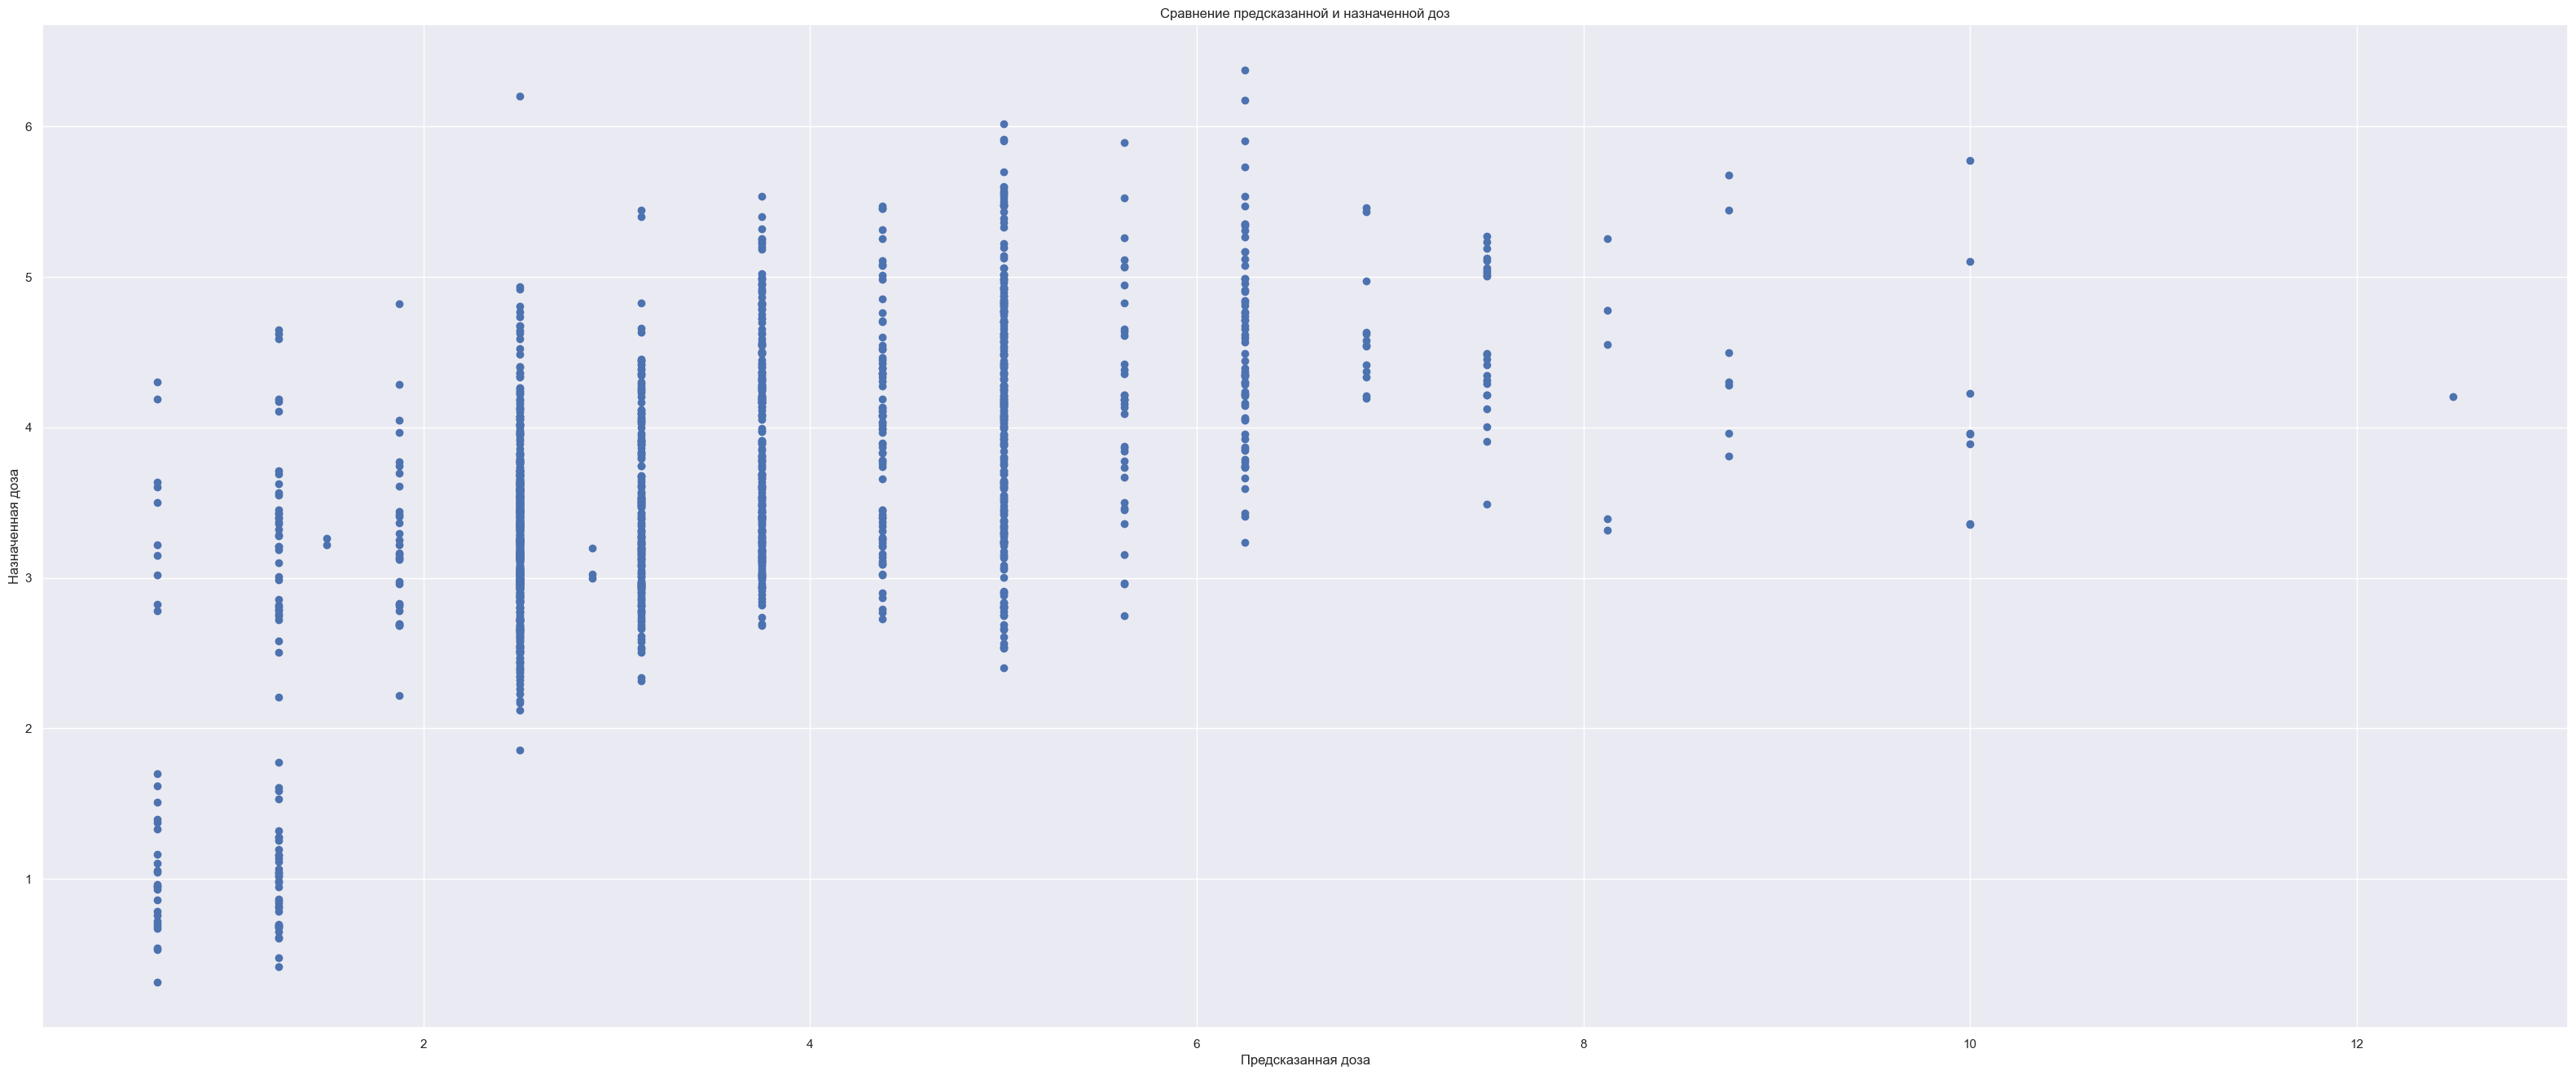

In [84]:
plt.scatter(y, y_pred)
plt.title('Сравнение предсказанной и назначенной доз')
plt.xlabel('Предсказанная доза')
plt.ylabel('Назначенная доза');

# Построение pipeline-а TPOT–ом

In [76]:
df = pd.read_excel(f'{ROOT_PATH}/data/processed/data_for_model.xlsx')
df = df.drop('id', axis=1)
df.head(3)

,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,pass_dose,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,57,7.5,3.11,1,0,0,13,3.32,1,0,...,0,0,0,0,0,0,0,0,0,0
1,57,7.5,3.32,1,0,0,15,2.01,2,0,...,0,0,0,0,0,0,0,0,0,0
2,50,5.0,2.01,0,1,0,26,2.75,1,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

In [78]:
df = pd.read_excel(f'{ROOT_PATH}/data/processed/data_for_model.xlsx')
df = df.drop('id', axis=1)
df.head(3)

,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,pass_dose,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,57,7.5,3.11,1,0,0,13,3.32,1,0,...,0,0,0,0,0,0,0,0,0,0
1,57,7.5,3.32,1,0,0,15,2.01,2,0,...,0,0,0,0,0,0,0,0,0,0
2,50,5.0,2.01,0,1,0,26,2.75,1,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
X, y = to_Xy(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25, random_state=RANDOM_SEED
)
print(f'{X_train.shape = }, {y_train.shape = }')
print(f'{X_test.shape = }, {y_test.shape = }')

X_train.shape = (1092, 85), y_train.shape = (1092,)
X_test.shape = (364, 85), y_test.shape = (364,)


In [80]:
# TODO: пока значения параметров выбраны для максимальной скорости, с ними качество низкое
tpot = TPOTRegressor(generations=1, population_size=1, random_state=RANDOM_SEED)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

-1.5865898595934647


## Запускаем TPOT с разными наборами признаков

In [81]:
df = pd.read_excel(f'{ROOT_PATH}/data/processed/data_for_model.xlsx')
df = df.drop('id', axis=1)
df.head(3)

,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,pass_dose,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,57,7.5,3.11,1,0,0,13,3.32,1,0,...,0,0,0,0,0,0,0,0,0,0
1,57,7.5,3.32,1,0,0,15,2.01,2,0,...,0,0,0,0,0,0,0,0,0,0
2,50,5.0,2.01,0,1,0,26,2.75,1,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
ranks = np.linspace(0.5, 2, num=4)
ranks.tolist()

[0.5, 1.0, 1.5, 2.0]

In [83]:
for rank_threshold in ranks:
    features_to_remove = find_minor_features(feature_ranking, rank_threshold)
    small_df = df.drop(columns=features_to_remove, axis=1)

    X, y = to_Xy(small_df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, test_size=0.25, random_state=RANDOM_SEED
    )

    # TODO: пока значения параметров выбраны для максимальной скорости, с ними качество низкое
    tpot = TPOTRegressor(generations=1, population_size=1, random_state=RANDOM_SEED)
    tpot.fit(X_train, y_train)
    print(rank_threshold, tpot.score(X_test, y_test))


0.5 -1.5865898595934647
1.0 -1.55148631858985
1.5 -1.5289379439733104
2.0 -1.5724975963413892
